In [1]:
import numpy as np
from PIL import ImageGrab
from PIL import Image
import cv2
import io
import time
%matplotlib inline 
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (15, 9)
import seaborn as sns
import pandas as pd
import numpy as np
from IPython.display import clear_output
from random import randint


In [2]:
import os
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
game_url = "game/dino.html"
chrome_driver_path = "../chromedriver.exe"
class Game:
    def __init__(self,custom_config=True):
        chrome_options = Options()
        chrome_options.add_argument("disable-infobars")
        self._driver = webdriver.Chrome(executable_path = chrome_driver_path,chrome_options=chrome_options)
        self._driver.set_window_position(x=-10,y=0)
        self._driver.set_window_size(200, 300)
        self._driver.get(os.path.abspath(game_url))
        if custom_config:
            self._driver.execute_script("Runner.config.ACCELERATION=0")
    def get_crashed(self):
        return self._driver.execute_script("return Runner.instance_.crashed")
    def get_playing(self):
        return self._driver.execute_script("return Runner.instance_.playing")
    def restart(self):
        self._driver.execute_script("Runner.instance_.config.CLEAR_TIME = "+ str(randint(1, 999)))
        self._driver.execute_script("Runner.instance_.restart()")
#         self._driver.refresh()
#         self.press_up()
        time.sleep(0.25)
    def press_up(self):
        self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)
    def press_down(self):
        self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_DOWN)
    def get_score(self):
        score_array = self._driver.execute_script("return Runner.instance_.distanceMeter.digits")
        score = ''.join(score_array)
        return int(score)
    def pause(self):
        return self._driver.execute_script("return Runner.instance_.stop()")
    def resume(self):
        return self._driver.execute_script("return Runner.instance_.play()")
    def end(self):
        self._driver.close()

In [3]:
class DinoAgent:
    def __init__(self,game):
        self._game = game;
        self.jump();
        time.sleep(.5)
    def is_running(self):
        return self._game.get_playing()
    def is_crashed(self):
        return self._game.get_crashed()
    def jump(self):
        self._game.press_up()
    def duck(self):
        self._game.press_down()

In [4]:
#processing image as required
def process_img(image):
    #game is already in grey scale canvas, canny to get only edges and reduce unwanted objects(clouds)
#     image = cv2.Canny(image, threshold1 = 100, threshold2 = 200)
#     image = image[10:140,0:200] #img[y:y+h, x:x+w]
#     image = resized_image = cv2.resize(image, (80, 80)) 
    image = cv2.resize(image, (0,0), fx = 0.15, fy = 0.10)
    image = image[2:38,10:50] #img[y:y+h, x:x+w]
    image = cv2.Canny(image, threshold1 = 200, threshold2 = 200)
    
    return  image

In [5]:
def grab_screen(_driver = None):
    screen =  np.array(ImageGrab.grab(bbox=(0,180,400,400)))
    image = process_img(screen)
    if _driver!=None:
        image = _driver.get_screenshot_as_png()
    return image

In [6]:
# print(grab_screen().shape)
# game = Game()
# dino = DinoAgent(game)
# last_time = time.time()
# while(True):
    
# # #     print('loop took {} seconds'.format(time.time()-last_time))
# # #     last_time = time.time()
# # #     cv2.imwrite("./img_data/dino"+str(time())+".jpg",image)
# # #     dino.duck()
# #     #exit on q pres
# # #     print('{0} {1} '.format(r_t,end_t))
# # #     cv2.imshow('window',game.grab_screen())
    
#     image = grab_screen()
#     cv2.imshow('window',image)
#     print(image.shape[0])
# #     cv2.destroyAllWindows()

# # #     from matplotlib import pyplot as plt
# # #     plt.imshow(image)
# # #     plt.title('my picture')
# # #     plt.show()

# # #     grab_screen()
# #     if(dino.is_crashed()):
# #         #jumping starts the game again if dino has crashed
# # #         temp = (game.get_score())
# #         game.restart()
#     if (cv2.waitKey(25) & 0xFF == ord('q')):
#         cv2.destroyAllWindows()
#         game.end()
# #         cv2.imwrite('dino.jpg',image)
#         break

In [7]:
import pickle
def save_obj(obj, name ):
    with open('objects/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('objects/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [8]:
#game parameters
ACTIONS = 2 # possible actions: jump, do nothing
GAMMA = 0.8 # decay rate of past observations original 0.99
OBSERVATION = 20000. # timesteps to observe before training
EXPLORE = 50000 #300000. # frames over which to anneal epsilon
FINAL_EPSILON = 0.0001 # final value of epsilon
INITIAL_EPSILON = 0.1 # starting value of epsilon
REPLAY_MEMORY = 50000 # number of previous transitions to remember
BATCH = 32 # size of minibatch
FRAME_PER_ACTION = 4
LEARNING_RATE = 1e-4

In [9]:
"""initial variable caching, done only once"""
# save_obj(FINAL_EPSILON,"epsilon")
# t = 0
# save_obj(t,"time")
# D = deque()
# save_obj(D,"D")

'initial variable caching, done only once'

In [10]:
img_rows , img_cols = 40,20
img_channels = 4 #We stack 4 frames

In [11]:
def buildmodel():
    print("Now we build the model")
    model = Sequential()
    model.add(Convolution2D(32, 8, 8, subsample=(4, 4), border_mode='same',input_shape=(img_cols,img_rows,img_channels)))  #80*80*4
    model.add(Activation('relu'))
    model.add(Convolution2D(64, 4, 4, subsample=(2, 2), border_mode='same'))
    model.add(Activation('relu'))
    model.add(Convolution2D(64, 3, 3, subsample=(1, 1), border_mode='same'))
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dense(ACTIONS))
    adam = Adam(lr=LEARNING_RATE)
    model.compile(loss='mse',optimizer=adam)
    print("We finish building the model")
    return model

In [12]:
def trainNetwork(model,game_state,observe=False):
    # open up a game state to communicate with emulator
    last_time = time.time()
    # store the previous observations in replay memory
    D = load_obj("D") #deque()
    # get the first state by doing nothing and preprocess the image to 80x80x4
    do_nothing = np.zeros(ACTIONS)
    do_nothing[0] =1 
    x_t, r_0, terminal = game_state.get_state(do_nothing)
    

    s_t = np.stack((x_t, x_t, x_t, x_t), axis=2)
    

    #In Keras, need to reshape
    s_t = s_t.reshape(1, s_t.shape[0], s_t.shape[1], s_t.shape[2])  #1*80*80*4
    initial_state = s_t

    if observe :#args['mode'] == 'Run':
        OBSERVE = 999999999    #We keep observe, never train
        epsilon = FINAL_EPSILON
        print ("Now we load weight")
        model.load_weights("model.h5")
        adam = Adam(lr=LEARNING_RATE)
        model.compile(loss='mse',optimizer=adam)
        print ("Weight load successfully")    
    else:                       #We go to training mode
        OBSERVE = OBSERVATION
        epsilon = load_obj("epsilon")#FINAL_EPSILON #INITIAL_EPSILON
        model.load_weights("model.h5")
        adam = Adam(lr=LEARNING_RATE)
        model.compile(loss='mse',optimizer=adam)

    t = load_obj("time")
    while (True):
        
        loss = 0
        Q_sa = 0
        action_index = 0
        r_t = 0
        a_t = np.zeros([ACTIONS])
        #choose an action epsilon greedy
        if t % FRAME_PER_ACTION == 0:
            if  random.random() <= epsilon:
                print("----------Random Action----------")
                action_index = random.randrange(ACTIONS)
                a_t[action_index] = 1
            else:
                q = model.predict(s_t)       #input a stack of 4 images, get the prediction
                max_Q = np.argmax(q)
                action_index = max_Q
                a_t[action_index] = 1
        #We reduced the epsilon gradually
        if epsilon > FINAL_EPSILON and t > OBSERVE:
            epsilon -= (INITIAL_EPSILON - FINAL_EPSILON) / EXPLORE #update to original asap

        #run the selected action and observed next state and reward
        x_t1, r_t, terminal = game_state.get_state(a_t)
        print('loop took {} seconds'.format(time.time()-last_time))
        last_time = time.time()
        x_t1 = x_t1.reshape(1, x_t1.shape[0], x_t1.shape[1], 1) #1x80x80x1
        s_t1 = np.append(x_t1, s_t[:, :, :, :3], axis=3)

        # store the transition in D
        D.append((s_t, action_index, r_t, s_t1, terminal))
        if len(D) > REPLAY_MEMORY:
            D.popleft()

        #only train if done observing
        if t > OBSERVE: 
            
            #sample a minibatch to train on
            minibatch = random.sample(D, BATCH)
            inputs = np.zeros((BATCH, s_t.shape[1], s_t.shape[2], s_t.shape[3]))   #32, 20, 40, 4
            targets = np.zeros((inputs.shape[0], ACTIONS))                         #32, 2

            #Now we do the experience replay
            for i in range(0, len(minibatch)):
                state_t = minibatch[i][0]
                action_t = minibatch[i][1]   #This is action index
                reward_t = minibatch[i][2]
                state_t1 = minibatch[i][3]
                terminal = minibatch[i][4]
                # if terminated, only equals reward

                inputs[i:i + 1] = state_t    #I saved down s_t

                targets[i] = model.predict(state_t)  # Hitting each buttom probability
                Q_sa = model.predict(state_t1)
                
                if terminal:
                    targets[i, action_t] = reward_t
                else:
                    targets[i, action_t] = reward_t + GAMMA * np.max(Q_sa)
            # targets2 = normalize(targets)
            loss += model.train_on_batch(inputs, targets)
            loss_df.loc[len(loss_df)] = loss
        else:
            #artificial time delay as training done with this delay
            loss_df.loc[len(loss_df)] = 0
            time.sleep(0.15)
        s_t = initial_state if terminal else s_t1
        t = t + 1
        
        # save progress every 10000 iterations
        if t % 1000 == 0:
            print("Now we save model")
            
            model.save_weights("model.h5", overwrite=True)
            save_obj(D,"D") #saving episodes
            save_obj(t,"time") #caching time steps
            save_obj(epsilon,"epsilon") #cache epsilon to avoid repeated randomness in actions
            loss_df.to_csv("./objects/loss_df.csv",index=False)
            scores_df.to_csv("./objects/scores_df.csv",index=False)
            actions_df.to_csv("./objects/actions_df.csv",index=False)
            clear_output()
            with open("model.json", "w") as outfile:
                json.dump(model.to_json(), outfile)

        # print info
        state = ""
        if t <= OBSERVE:
            state = "observe"
        elif t > OBSERVE and t <= OBSERVE + EXPLORE:
            state = "explore"
        else:
            state = "train"

        print("TIMESTEP", t, "/ STATE", state, \
            "/ EPSILON", epsilon, "/ ACTION", action_index, "/ REWARD", r_t, \
            "/ Q_MAX " , np.max(Q_sa), "/ Loss ", loss)

    print("Episode finished!")
    print("************************")

In [13]:
loss_df = pd.read_csv("./objects/loss_df.csv")
scores_df = pd.read_csv("./objects/scores_df.csv")
actions_df = pd.read_csv("./objects/actions_df.csv")
q_max_df = pd.read_csv("./objects/q_values.csv")

In [14]:
def playGame(observe=False):
    game = Game()
    dino = DinoAgent(game)
    game_state = Game_sate(dino,game)
    model = buildmodel()
    trainNetwork(model,game_state,observe=observe)

In [15]:
class Game_sate:
    def __init__(self,agent,game):
        self._agent = agent
        self._game = game
        self._display = show_img()
        self._display.__next__()
    def get_state(self,actions):
        actions_df.loc[len(actions_df)] = actions[1]
        reward = 0.1
        is_over = False
        if actions[1] == 1:
            self._agent.jump()

        image = grab_screen()
        self._display.send(image)

        if self._agent.is_crashed():
            scores_df.loc[len(loss_df)] = self._game.get_score()
            self._game.restart()
            reward = -5
            is_over = True
        return image, reward, is_over

In [16]:
from keras.models import model_from_json
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD , Adam
import tensorflow as tf
from keras.callbacks import TensorBoard
from collections import deque
import random
import json

Using TensorFlow backend.


In [17]:
def show_img(graphs = False):
    """
    Show images in new window
    """
    while True:
        screen = (yield)
        window_title = "logs" if graphs else "game_play"
        cv2.namedWindow(window_title, cv2.WINDOW_NORMAL)        # Create window with freedom of dimensions
        imS = cv2.resize(screen, (800, 400)) 
        cv2.imshow(window_title, screen)
#         cv2.imwrite("screenshot"+str(frame)+".png",screen)
        if (cv2.waitKey(1) & 0xFF == ord('q')):
            cv2.destroyAllWindows()
            break

In [18]:
playGame(observe=False);

Now we build the model


C:\Users\ravi7\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (8, 8), input_shape=(20, 40, 4..., strides=(4, 4), padding="same")`
  after removing the cwd from sys.path.
C:\Users\ravi7\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (4, 4), strides=(2, 2), padding="same")`
  
C:\Users\ravi7\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), strides=(1, 1), padding="same")`
  


We finish building the model
loop took 0.7118477821350098 seconds
TIMESTEP 633001 / STATE train / EPSILON 9.999999990062844e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  -1.242 / Loss  0.139846950769
loop took 0.9065465927124023 seconds
TIMESTEP 633002 / STATE train / EPSILON 9.999999990062844e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  -0.858274 / Loss  0.378338456154
loop took 0.21962380409240723 seconds
TIMESTEP 633003 / STATE train / EPSILON 9.999999990062844e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  -0.240669 / Loss  0.264907062054
loop took 0.20107316970825195 seconds
TIMESTEP 633004 / STATE train / EPSILON 9.999999990062844e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  0.43229 / Loss  0.376168131828
loop took 0.5862467288970947 seconds
TIMESTEP 633005 / STATE train / EPSILON 9.999999990062844e-05 / ACTION 1 / REWARD -5 / Q_MAX  -0.173112 / Loss  0.547347664833
loop took 0.2994983196258545 seconds
TIMESTEP 633006 / STATE train / EPSILON 9.999999990062844e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  -1.27928 / Loss  0

TIMESTEP 633051 / STATE train / EPSILON 9.999999990062844e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  -1.76712 / Loss  0.297997415066
loop took 0.34244751930236816 seconds
TIMESTEP 633052 / STATE train / EPSILON 9.999999990062844e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  -4.14537 / Loss  0.266021132469
loop took 0.38593053817749023 seconds
TIMESTEP 633053 / STATE train / EPSILON 9.999999990062844e-05 / ACTION 1 / REWARD 0.1 / Q_MAX  -0.0148675 / Loss  0.185953319073
loop took 0.29683756828308105 seconds
TIMESTEP 633054 / STATE train / EPSILON 9.999999990062844e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  -0.158315 / Loss  0.247628942132
loop took 0.7055282592773438 seconds
TIMESTEP 633055 / STATE train / EPSILON 9.999999990062844e-05 / ACTION 0 / REWARD -5 / Q_MAX  -0.277989 / Loss  0.107746690512
loop took 0.4116191864013672 seconds
TIMESTEP 633056 / STATE train / EPSILON 9.999999990062844e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  -0.170606 / Loss  0.647695600986
loop took 0.38136887550354004 seconds
TIMESTEP

TIMESTEP 633101 / STATE train / EPSILON 9.999999990062844e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  -0.40007 / Loss  0.274786561728
loop took 0.33599114418029785 seconds
TIMESTEP 633102 / STATE train / EPSILON 9.999999990062844e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  -0.37957 / Loss  0.341670095921
loop took 0.31558704376220703 seconds
TIMESTEP 633103 / STATE train / EPSILON 9.999999990062844e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  -4.60274 / Loss  0.312995880842
loop took 0.3133425712585449 seconds
TIMESTEP 633104 / STATE train / EPSILON 9.999999990062844e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  0.0396852 / Loss  0.289255350828
loop took 0.33449459075927734 seconds
TIMESTEP 633105 / STATE train / EPSILON 9.999999990062844e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  -0.490043 / Loss  0.790246844292
loop took 0.32065534591674805 seconds
TIMESTEP 633106 / STATE train / EPSILON 9.999999990062844e-05 / ACTION 0 / REWARD 0.1 / Q_MAX  -0.290383 / Loss  0.215701639652
loop took 0.3190155029296875 seconds
TIMESTEP 

StopIteration: 

In [18]:
def show_plots(realtime = True,t=0):
    fig, axs = plt.subplots(ncols=2,nrows =2)
    loss_df['loss'] = loss_df['loss'].astype('float') 
    loss_df.plot(use_index=True,ax=axs[0,0])
    scores_df.plot(ax=axs[0,1])
    sns.distplot(actions_df,ax=axs[1,0])
#     q_max_df.plot(ax = axs[1,1])
    imgg = fig.canvas.draw()
    graph_img = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    graph_img = graph_img.reshape(fig.canvas.get_width_height()[::-1] + (3,))
#     disp = show_img(graphs=True)
#     disp.__next__()
    cv2.imwrite("logs/progress/pg"+str(t)+".png",graph_img) if realtime else 0

C:\Users\ravi7\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


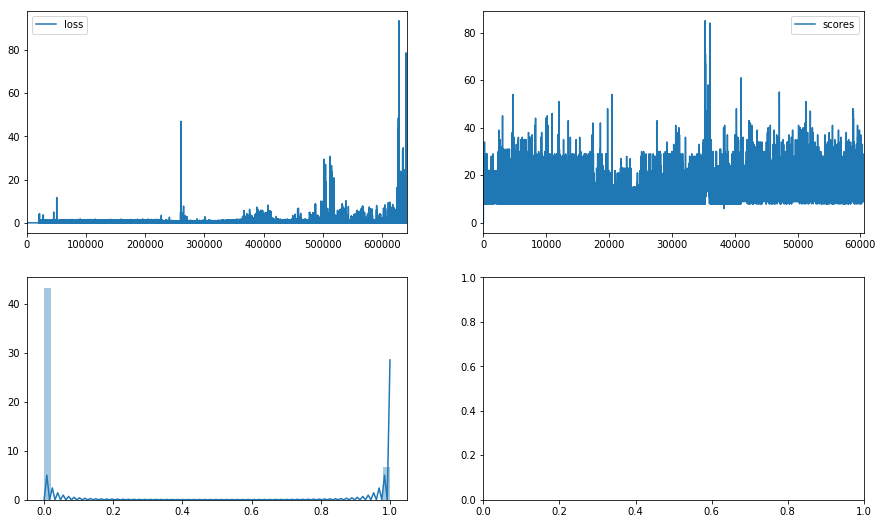

In [19]:
show_plots(realtime=False)

In [22]:
from keras.utils import plot_model
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
view_mode = buildmodel()
view_mode.load_weights("model.h5")
adam = Adam(lr=LEARNING_RATE)
view_mode.compile(loss='mse',optimizer=adam)
plot_model(view_mode, to_file='model.png')

Now we build the model
We finish building the model


C:\Users\ravi7\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (8, 8), input_shape=(20, 40, 4..., strides=(4, 4), padding="same")`
  after removing the cwd from sys.path.
C:\Users\ravi7\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (4, 4), strides=(2, 2), padding="same")`
  
C:\Users\ravi7\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), strides=(1, 1), padding="same")`
  


In [ ]:
import pydot